In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt

## Exploring MNIST dataset

### Downloading/Loading torchvision.dataset.MNIST. 

In [2]:
# Training dataset

dataset = MNIST(root='data/')
len(dataset)

60000

In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [4]:
# Testing dataset

test_dataset = MNIST(root='data/', train = False)
len(test_dataset)

10000

Plotting first 10 images in the dataset along with their target labels.

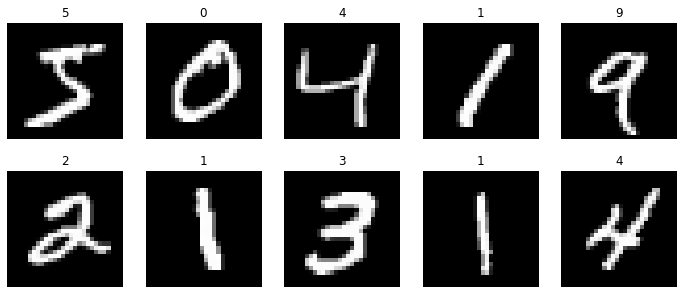

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

for i in range(10):
    axes[i//5, i%5].imshow(dataset[i][0], cmap='gray')
    axes[i//5, i%5].set_title(dataset[i][1])
    axes[i//5, i%5].axis("off")

### Loading MNIST as tensors

torch.Size([1, 28, 28])


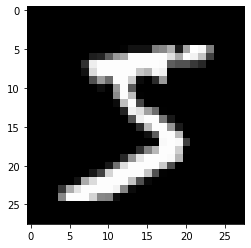

In [6]:
dataset = MNIST(root='data/', transform=transforms.ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

img_tensor, label = dataset[0]
print(img_tensor.shape)

plt.imshow(img_tensor[0,:,:], cmap='gray')
plt.show()

### Splitting dataset to training and validation

In [7]:
val_split = (1/6)

val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size

In [8]:
train_set, val_set = random_split(dataset, [train_size, val_size])

print(len(train_set), len(val_set))

50000 10000


### Creating dataloader

In [9]:
batch_size = 10000

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)

### Defining model

In [10]:
input_size = 28*28
num_classes = 10

In [40]:
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, out_size, loss_func, learning_rate):
        super().__init__()
        # Loss function
        self.loss_func = loss_func
        # Hidden Layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        # Output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        # Optimizer
        self.opt = torch.optim.SGD(self.parameters(), lr=learning_rate)
            
    ## Returns the value after forward pass
    def forward(self, x):
        
        # Reshaping from 28x28 to 784, and first value (-1)
        x = x.reshape(-1, 784)
        # First linear layer
        x1 = self.linear1(x)
        # Activation layer
        a1 = F.relu(x1)
        # Output linear layer
        x2 = self.linear2(a1)
        return x2
    
    ## Returns loss for a training batch
    def training_step(self, batch):
        images, labels = batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        loss = self.loss_func(out, labels) 
        return loss
    
    ## Returns the loss and accuracy for a validation batch
    def validation_step(self, val_batch):
        images, labels = val_batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        val_loss = self.loss_func(out, labels) 
        val_acc = accuracy(out, labels)
        
        return {"val_loss":val_loss, "val_acc":val_acc}
    
    ## Returns mean loss and mean accuracy from the losses and accuracies of all the batches
    def validation_epoch_end(self, outputs):
        
        # Losses for each batch
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Mean loss for all batch
        batch_mean_loss = torch.tensor(batch_losses).mean()
        
        # Accuracies for each batches
        batch_accs = [x['val_acc'] for x in outputs]
        
        # Mean accuracy for all batches
        batch_mean_acc = torch.tensor(batch_accs).mean()
        
        return {"val_loss":batch_mean_loss, "val_acc":batch_mean_acc}
    
    ## Prints validation loss and accuracy for epoch (mean of all batches)
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Checking sample outputs from instantiated model using one batch of dataset.

### Evaluation metric

Defining accuracy as total correct no. of predictions predictions divided by total no. of predictions.

In [41]:
# Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Training

In [42]:
# Utility function to train the model

def fit(epochs, model, train_loader, val_loader):
    print("Training")
    
    # For recording epoch wise results
    history = []
    
    for i in range(epochs):
        for batch in train_loader:
            
            # Make prediction & Calculate loss
            loss = model.training_step(batch)
            
            # Compute gradients
            loss.backward()
            
            # Update parameters using gradients
            model.opt.step()
            
            # Reset gradients to zero
            model.opt.zero_grad()
            
        ## Validation phase 
        result = evaluate(model, val_loader)
        model.epoch_end(i, result)
        history.append(result)
            
    return history

In [43]:
def evaluate(model, val_loader):
    
    # List containing evaluations for every batch
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

### Creating and training model

In [44]:
# Hyperparameters
hidden_size = 32
loss_func = F.cross_entropy
learning_rate = 0.1

# Create model
model = Model(input_size = input_size, hidden_size = hidden_size, out_size = num_classes, 
              loss_func = loss_func, 
              learning_rate = learning_rate)

In [45]:
history_1 = fit(10, model, train_loader, val_loader)

Training
Epoch [0], val_loss: 2.2285, val_acc: 0.2810
Epoch [1], val_loss: 2.1346, val_acc: 0.3322
Epoch [2], val_loss: 2.0254, val_acc: 0.4460
Epoch [3], val_loss: 1.8981, val_acc: 0.5736
Epoch [4], val_loss: 1.7557, val_acc: 0.6551
Epoch [5], val_loss: 1.6046, val_acc: 0.7049
Epoch [6], val_loss: 1.4547, val_acc: 0.7333
Epoch [7], val_loss: 1.3146, val_acc: 0.7504
Epoch [8], val_loss: 1.1903, val_acc: 0.7638
Epoch [9], val_loss: 1.0839, val_acc: 0.7798


In [50]:
history_2 = fit(10, model, train_loader, val_loader)

Training
Epoch [0], val_loss: 0.9950, val_acc: 0.7961
Epoch [1], val_loss: 0.9209, val_acc: 0.8074
Epoch [2], val_loss: 0.8591, val_acc: 0.8204
Epoch [3], val_loss: 0.8072, val_acc: 0.8272
Epoch [4], val_loss: 0.7635, val_acc: 0.8349
Epoch [5], val_loss: 0.7263, val_acc: 0.8397
Epoch [6], val_loss: 0.6938, val_acc: 0.8451
Epoch [7], val_loss: 0.6660, val_acc: 0.8480
Epoch [8], val_loss: 0.6413, val_acc: 0.8524
Epoch [9], val_loss: 0.6193, val_acc: 0.8546


Now we plot the evaluation metrics for all epochs.

In [52]:
losses = [l['val_loss'] for l in history_1+history_2]
acc = [a['val_acc'] for a in history_1+history_2]

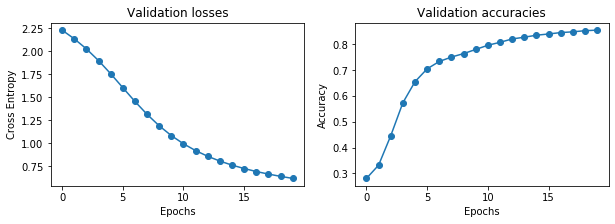

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

axes[0].plot(losses, '-o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Cross Entropy")
axes[0].set_title("Validation losses")

axes[1].plot(acc, '-o')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation accuracies")
plt.show()

### Checking model performance on test dataset

In [58]:
test_loader = DataLoader(test_dataset, batch_size)


In [59]:
result = evaluate(model, test_loader)
print("Test Loss = {:.4f}, Test accuracy = {:.4F}".format(result['val_loss'], result['val_acc']))

Test Loss = 0.5938, Test accuracy = 0.8659
